<a href="https://colab.research.google.com/github/sattviksahai/CS583B_Recitation/blob/master/RNN_IMDB_reviews_reference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extract data

In [2]:
!tar -xf 'drive/My Drive/aclImdb_v1.tar.gz'
! rm -rf aclImdb/train/unsup/
!ls

aclImdb  dense_imdb_model.h5  drive  imdb_model.h5  sample_data


Read Training Data

In [0]:
import os
imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels_train = []
texts_train = []
for label_type in ['pos', 'neg']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts_train.append(f.read())
      f.close()
      if label_type == 'neg':
        labels_train.append(0)
      else:
        labels_train.append(1)

In [4]:
print('Number of training samples: '+str(len(texts_train)))
print('Number of training labels: '+str(len(labels_train)))

Number of training samples: 25000
Number of training labels: 25000


Display random review with label

In [5]:
import numpy as np

i=np.random.randint(len(labels_train))
print('label #'+str(i)+': '+str(labels_train[i]))
print('text #'+str(i)+':')
print(texts_train[i])

label #24565: 0
text #24565:
When anyone comes into a film of this type of film it's not without saying that an overdose of that great over-the-counter brain-medicine, Suspension of Disbelief, comes in mighty handy.<br /><br />Jeanette MacDonald plays two roles: Anna/Brigitta, the woman who Nelson Eddy has ignored since the beginning of time, but who also is -- an angel sent to Earth.<br /><br />My reaction when I saw this was a mute gasp of "Hunh?" Where have I seen this before? It turns out, I have seen it before, but in a movie made much later than this one. DATE WITH AN ANGEL, a forgettable pile of dreck made in 1987, cashed in on the ethereal beauty of one Emmanuelle Beart who had no speaking lines, also wore a blond wig, and made life hell for soap-actor Michael Knight. Much worse in every conceivable angle with ultra-low 80s values but more than likely an updated version of this 1942 turkey.<br /><br />Anyway, not to elaborate, this is not a memorable film and stands as a doorst

Tokenize the text

In [6]:
from keras.preprocessing.text import Tokenizer

vocabulary = 10000
tokenizer = Tokenizer(num_words=vocabulary)
tokenizer.fit_on_texts(texts_train)

word_index = tokenizer.word_index
sequences_train = tokenizer.texts_to_sequences(texts_train)

Using TensorFlow backend.


Add Padding

In [0]:
from keras import preprocessing

word_num = 20
x_train_val = preprocessing.sequence.pad_sequences(sequences_train, maxlen=word_num)

In [8]:
print(x_train_val.shape)

(25000, 20)


Training Validation split

In [9]:
split_ratio = 0.8

indices = np.arange(x_train_val.shape[0])
np.random.shuffle(indices)

x_train = x_train_val[indices[:int(len(indices)*split_ratio)]]
x_val = x_train_val[indices[int(len(indices)*split_ratio):]]

labels_train = np.array(labels_train)
y_train = labels_train[indices[:int(len(indices)*split_ratio)]]
y_val = labels_train[indices[int(len(indices)*split_ratio):]]
print('Shape of training data: ', x_train.shape)
print('Shape of training labels: ', y_train.shape)
print('Shape of validation data: ', x_val.shape)
print('Shape of validation labels: ', y_val.shape)

Shape of training data:  (20000, 20)
Shape of training labels:  (20000,)
Shape of validation data:  (5000, 20)
Shape of validation labels:  (5000,)


Define Model
Options:
a) Simple RNN
b) LSTM
c) Stacked LSTM
d) Bidirectional LSTM
e) Conv1D

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Flatten, LSTM, Bidirectional, Conv1D

embedding_dim = 32
h_dim = 32

model = Sequential()
model.add(Embedding(vocabulary, embedding_dim, input_length=word_num))
model.add(SimpleRNN(h_dim, activation='tanh', return_sequences=False))
# model.add(LSTM(h_dim, activation='tanh', return_sequences=True, dropout=0.5))
# model.add(LSTM(h_dim, activation='tanh', return_sequences=True, dropout=0.5))
# model.add(Bidirectional(LSTM(h_dim, activation='tanh', return_sequences=False, dropout=0.5)))
# model.add(Conv1D(16, 5, activation='relu'))
# model.add(Conv1D(32, 5, activation='relu'))
# model.add(Conv1D(64, 5, activation='relu'))
# model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 32)            320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 16, 16)            2576      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 32)            2592      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 64)             10304     
_________________________________________________________________
dense (Dense)                (None, 8, 1)              65        
Total params: 335,537
Trainable params: 335,537
Non-trainable params: 0
_________________________________________________________________


Define Optimizer

In [0]:
from tensorflow.keras import optimizers

epochs = 5

model.compile(optimizer=optimizers.RMSprop(lr=0.01),
            loss='binary_crossentropy', metrics=['acc'])

Train

In [12]:
history = model.fit(x_train, y_train, epochs=epochs,
                    batch_size=16, validation_data=(x_val, y_val))

Epoch 1/5
1250/1250 [==============================] - 6s 5ms/step - loss: 0.6081 - acc: 0.6600 - val_loss: 0.5713 - val_acc: 0.7071
Epoch 2/5
1250/1250 [==============================] - 6s 5ms/step - loss: 0.5342 - acc: 0.7368 - val_loss: 0.5457 - val_acc: 0.7222
Epoch 3/5
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4965 - acc: 0.7645 - val_loss: 0.5434 - val_acc: 0.7197
Epoch 4/5
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4656 - acc: 0.7882 - val_loss: 0.5926 - val_acc: 0.6982
Epoch 5/5
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4349 - acc: 0.8102 - val_loss: 0.6224 - val_acc: 0.7053


Visualize training

[0.6599562764167786, 0.7368187308311462, 0.7645062208175659, 0.788224995136261, 0.8102437257766724]


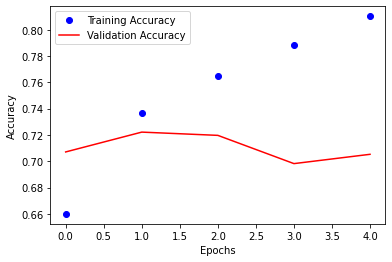

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(epochs) # 50 is the number of epochs
train_acc = history.history['acc']
valid_acc = history.history['val_acc']
print(train_acc)
plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, valid_acc, 'r', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
model.save('imdb_model.h5')

Read Test data

In [0]:
import os
imdb_dir = './aclImdb'
test_dir = os.path.join(imdb_dir, 'test')
labels_test = []
texts_test = []
for label_type in ['pos', 'neg']:
  dir_name = os.path.join(test_dir, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts_test.append(f.read())
      f.close()
      if label_type == 'neg':
        labels_test.append(0)
      else:
        labels_test.append(1)

In [16]:
print('Number of training samples: '+str(len(texts_test)))
print('Number of training labels: '+str(len(labels_test)))

Number of training samples: 25000
Number of training labels: 25000


Tokenize the text

In [0]:
sequences_test = tokenizer.texts_to_sequences(texts_test)

Padding

In [0]:
x_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=word_num)

Evaluate model

In [19]:
loss_and_acc = model.evaluate(x_test, np.array(labels_test))
print("loss = ",str(loss_and_acc[0]))
print("acc = ", str(loss_and_acc[1]))

782/782 [==============================] - 2s 3ms/step - loss: 0.6233 - acc: 0.7002
loss =  0.623349666595459
acc =  0.700190007686615
